Загружаем данные.

Последние семь дней (это просто продублированные значения из таблицы за последнюю известную дату - 8 дней назад).

Вам нужно спрогнозировать цену биткоина (Price) на последние семь дней.

In [3]:
import pandas as pd
from matplotlib import pyplot as plt

data = pd.read_csv("Bitcoin_kaggle.csv",
                  delimiter=';',
                  parse_dates=True,
                  index_col='Date'
                  )

print(len(data))

data = data.sort_index()

547


Удалим колонку Change%, так как она избыточна, является комбинацией других колонок, Vol. (объёмы торгов) 
приведем к нормальному виду, High и Low превратим в колонку Variance

In [4]:
data = data.drop(["Change %"], axis=1)

In [5]:
#Удалим запятые
data[['Price', 'Open', 'High', 'Low']] = data[['Price', 'Open', 'High', 'Low']].apply(lambda x: x.astype(str).str.replace(',', '').astype(float))

In [6]:
#Проверка
data.head()

,Price,Open,High,Low,Vol.
Date,,,,,
2022-01-14,43073.3,42562.2,43435.1,41848.7,50.50K
2022-01-15,43097.0,43073.6,43777.9,42586.1,31.44K
2022-01-16,43079.1,43079.2,43462.0,42643.3,28.66K
2022-01-17,42209.3,43080.5,43179.6,41559.4,41.44K
2022-01-18,42364.6,42209.9,42674.2,41300.7,47.32K


In [7]:
data["Variance"] = data["High"] - data["Low"]

In [8]:
data = data.drop(["High", "Low"], axis=1)

In [9]:
data = data.drop(["Open"], axis=1)

In [10]:
data.head(50)

,Price,Vol.,Variance
Date,,,
2022-01-14,43073.3,50.50K,1586.4
2022-01-15,43097.0,31.44K,1191.8
2022-01-16,43079.1,28.66K,818.7
2022-01-17,42209.3,41.44K,1620.2
2022-01-18,42364.6,47.32K,1373.5
2022-01-19,41677.8,53.77K,1397.1
2022-01-20,40715.9,65.28K,2918.8
2022-01-21,36475.5,155.80K,5600.7
2022-01-22,35075.2,138.09K,2633.8


 Попробуем оставить всё признаки кроме Change

In [11]:
data["Vol."] = data["Vol."].apply(lambda x: (float(x.replace("K","")) * 1000) if "K" in x else (float(x.replace("M","")) * 1000000) if "M" in x 
                                  else (float(x.replace("B","")) * 1000000000) if "B" in x else float(x))

In [16]:
#отмасштабируем признаки
from sklearn.preprocessing import StandardScaler
price_scaler = StandardScaler()
data["Price"] = price_scaler.fit_transform(data["Price"][:-7].values.reshape(-1,1))

ValueError: Length of values (540) does not match length of index (547)

<Axes: xlabel='Date'>

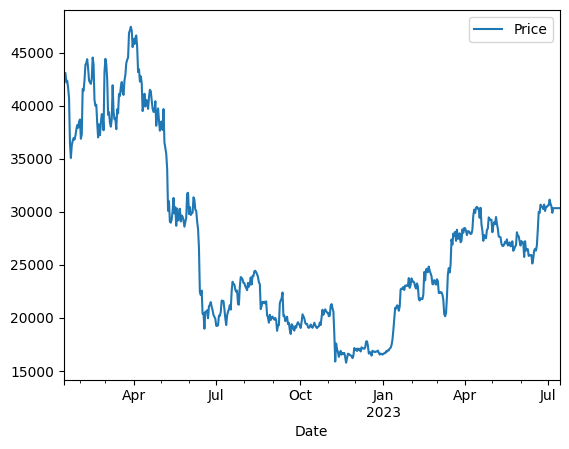

In [ ]:
data = data[['Price']]

data.plot()

In [16]:
def code_mean(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].mean())

Извлечем признаки

In [17]:
target = "Price"

def preprocess_data(data, lag_start=7, lag_end=20, test_size=0.02):

    data = pd.DataFrame(data.copy())

    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data) * (1 - test_size))
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data[f"lag_{i}"] = data[target].shift(i)

    data["day"] = data.index.day

    # считаем средние только по тренировочной части, чтобы избежать лика
    data["day_average"] = list(map(code_mean(data[:test_index], "day", target).get, data.day))

    # выкидываем закодированные средними признаки
    data.drop(["day"], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop([target], axis=1)
    y_train = data.loc[:test_index][target]
    X_test = data.loc[test_index:].drop([target], axis=1)
    y_test = data.loc[test_index:][target]

    return X_train, X_test, y_train, y_test

Обучим линейную регрессию (подберем размер теста так, чтобы в него попали ровно те 7 дней, для которых мы делаем прогноз)

7


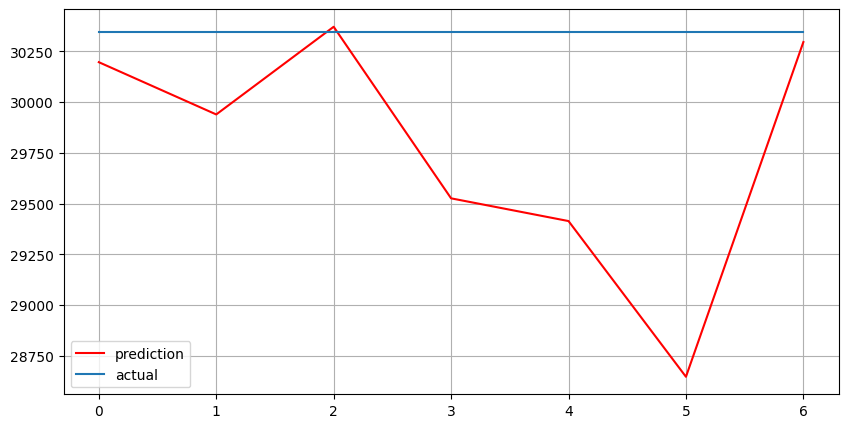

In [6]:
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = preprocess_data(data, test_size=0.035, lag_start=7, lag_end=14)

print(len(y_test))

lr = LinearRegression()
lr.fit(X_train, y_train)
preds = lr.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(preds, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")

In [12]:
X_train.head()

,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,day_average
0,40715.9,41677.8,42364.6,42209.3,43079.1,43097.0,43073.3,26812.735294
1,36475.5,40715.9,41677.8,42364.6,42209.3,43079.1,43097.0,27298.147059
2,35075.2,36475.5,40715.9,41677.8,42364.6,42209.3,43079.1,26693.600000
3,36269.5,35075.2,36475.5,40715.9,41677.8,42364.6,42209.3,26623.453333
4,36686.3,36269.5,35075.2,36475.5,40715.9,41677.8,42364.6,27501.290000


Сохраним прогноз в файл и отправим на kaggle.

In [7]:
X_test['Date'] = data.index[-7:]
X_test['Price'] = preds

X_test.set_index('Date', inplace=True)

In [8]:
X_test[['Price']]

,Price
Date,
2023-07-08,30196.939547
2023-07-09,29939.525845
2023-07-10,30371.300482
2023-07-11,29526.355905
2023-07-12,29414.429412
2023-07-13,28647.518808
2023-07-14,30296.037932


In [9]:
X_test[['Price']].to_csv("prediction_baseline.csv")

In [18]:
#теперь попробуем использовать дефолтный катбуст
from catboost import CatBoostRegressor
model = CatBoostRegressor()
model.fit(X_train, y_train)
preds = model.predict(X_test)

Learning rate set to 0.037013
0:	learn: 7898.0799812	total: 2.95ms	remaining: 2.95s
1:	learn: 7653.5177855	total: 4.78ms	remaining: 2.38s
2:	learn: 7415.1156907	total: 6.22ms	remaining: 2.07s
3:	learn: 7182.1875696	total: 7.66ms	remaining: 1.91s
4:	learn: 6972.6135206	total: 10.3ms	remaining: 2.04s
5:	learn: 6762.9319467	total: 12.4ms	remaining: 2.05s
6:	learn: 6568.9376630	total: 15.1ms	remaining: 2.15s
7:	learn: 6385.9156734	total: 16.9ms	remaining: 2.1s
8:	learn: 6203.8927762	total: 18.5ms	remaining: 2.04s
9:	learn: 6025.7442713	total: 20.1ms	remaining: 1.99s
10:	learn: 5847.2052744	total: 21.8ms	remaining: 1.96s
11:	learn: 5681.8906372	total: 24ms	remaining: 1.98s
12:	learn: 5530.1623147	total: 25.8ms	remaining: 1.96s
13:	learn: 5373.6777078	total: 27.5ms	remaining: 1.94s
14:	learn: 5226.9705904	total: 29.3ms	remaining: 1.92s
15:	learn: 5090.9843489	total: 31ms	remaining: 1.91s
16:	learn: 4965.5469507	total: 33.3ms	remaining: 1.93s
17:	learn: 4833.9644828	total: 35.2ms	remaining: 1

In [19]:
X_test['Date'] = data.index[-7:]
X_test['Price'] = preds

X_test.set_index('Date', inplace=True)
X_test[['Price']].to_csv("prediction_baseline_catboost.csv")